# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

    сalls — количество звонков,
    minutes — суммарная длительность звонков в минутах,
    messages — количество sms-сообщений,
    mb_used — израсходованный интернет-трафик в Мб,
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [14]:
#Библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
#from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
#from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.duplicated().sum()

0

In [5]:
df.calls = df.calls.astype("int")
df.messages = df.messages.astype("int")

Так как количество звонков и сообщений не может быть вещественны числом, превели данные колонки в целый тип данны. 

In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Мультиколлинеарность возникает, когда в модели множественной регрессии есть две или более независимых переменных, которые имеют между собой высокую корреляцию. Мультиколлинеарность может быть обнаружена с помощью различных методов, одним из которых является фактор инфляции дисперсии ( VIF ).

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[[ 'calls', 'minutes' , 'messages' , 'mb_used', 'is_ultra' ]]

vif_data = pd.DataFrame()
vif_data[ "feature" ] = X.columns

vif_data[ "VIF" ] = [variance_inflation_factor(X.values, i)
for i in range ( len (X.columns))]

print (vif_data)

    feature         VIF
0     calls  129.355144
1   minutes  126.502139
2  messages    2.236643
3   mb_used    4.467798
4  is_ultra    1.577978


Про мультиколлинеарность, раньше не знала, выше то что смогла найти, но до коца не поняла верно или нет. Увидела большую корреляцию между минутами и звонками, что походу и подтврдило фактор инфляции дисперсии ( VIF ). Можешь пояснить правильно я поняла и сделала или нет...? И не поняла что ты имел под этим преложением:  Можно еще отдельно проверить датасет на сбалансированность классов в таргете. 

## Разбейте данные на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки. 60% - train set,
20% - validation set,
20% - test set

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [10]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)
print(f"Количество строк в features_train: {features_train.shape}")
print(f"Количество строк в target_train: {target_train.shape}")

Количество строк в features_train: (1928, 4)
Количество строк в target_train: (1928,)


In [11]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)
print(f"Количество строк в features_test: {features_test.shape}")
print(f"Количество строк в features_valid: {features_valid.shape}")
print(f"Количество строк в target_test: {target_test.shape}")
print(f"Количество строк в target_valid: {target_valid.shape}")

Количество строк в features_test: (643, 4)
Количество строк в features_valid: (643, 4)
Количество строк в target_test: (643,)
Количество строк в target_valid: (643,)


## Исследуйте модели

Исследуем качество разных моделей, меняя гиперпараметры. Кратко напишем выводы исследования.

### DecisionTreeClassifier

 23%|██▎       | 13/57 [00:00<00:00, 125.63it/s]

max_depth = 1 : 0.7293934681181959
max_depth = 2 : 0.7682737169517885
max_depth = 3 : 0.7993779160186625
max_depth = 4 : 0.7744945567651633
max_depth = 5 : 0.8118195956454122
max_depth = 6 : 0.7993779160186625
max_depth = 7 : 0.7978227060653188
max_depth = 8 : 0.7838258164852255
max_depth = 9 : 0.7947122861586314
max_depth = 10 : 0.80248833592535
max_depth = 11 : 0.7807153965785381
max_depth = 12 : 0.7682737169517885
max_depth = 13 : 0.7589424572317263
max_depth = 14 : 0.7402799377916018
max_depth = 15 : 0.7402799377916018
max_depth = 16 : 0.7278382581648523
max_depth = 17 : 0.7371695178849145
max_depth = 18 : 0.7309486780715396
max_depth = 19 : 0.7200622083981337
max_depth = 20 : 0.7200622083981337
max_depth = 21 : 0.7247278382581649
max_depth = 22 : 0.7247278382581649


 65%|██████▍   | 37/57 [00:00<00:00, 93.58it/s] 

max_depth = 23 : 0.7247278382581649
max_depth = 24 : 0.7247278382581649
max_depth = 25 : 0.7247278382581649
max_depth = 26 : 0.7247278382581649
max_depth = 27 : 0.7247278382581649
max_depth = 28 : 0.7247278382581649
max_depth = 29 : 0.7247278382581649
max_depth = 30 : 0.7247278382581649
max_depth = 31 : 0.7247278382581649
max_depth = 32 : 0.7247278382581649
max_depth = 33 : 0.7247278382581649
max_depth = 34 : 0.7247278382581649
max_depth = 35 : 0.7247278382581649
max_depth = 36 : 0.7247278382581649
max_depth = 37 : 0.7247278382581649
max_depth = 38 : 0.7247278382581649
max_depth = 39 : 0.7247278382581649
max_depth = 40 : 0.7247278382581649


100%|██████████| 57/57 [00:00<00:00, 95.84it/s]

max_depth = 41 : 0.7247278382581649
max_depth = 42 : 0.7247278382581649
max_depth = 43 : 0.7247278382581649
max_depth = 44 : 0.7247278382581649
max_depth = 45 : 0.7247278382581649
max_depth = 46 : 0.7247278382581649
max_depth = 47 : 0.7247278382581649
max_depth = 48 : 0.7247278382581649
max_depth = 49 : 0.7247278382581649
max_depth = 50 : 0.7247278382581649
max_depth = 51 : 0.7247278382581649
max_depth = 52 : 0.7247278382581649
max_depth = 53 : 0.7247278382581649
max_depth = 54 : 0.7247278382581649
max_depth = 55 : 0.7247278382581649
max_depth = 56 : 0.7247278382581649
max_depth = 57 : 0.7247278382581649
Оценка правильности наилучшей модели на валидационной выборке: 0.8118195956454122 Максимальная глубина: 5


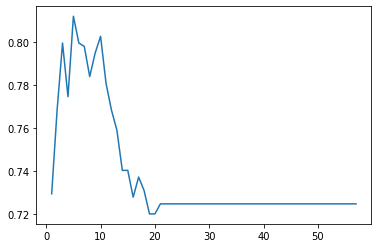

In [21]:

best_model_DTC = None
best_result_DTC = 0
best_depth_DTC = 0
list_valid = []
for i in tqdm(range(1, 58)):
    model_DTC = DecisionTreeClassifier(max_depth=i, random_state=12345)
    model_DTC.fit(features_train, target_train)
    predictions_valid_DTC  = model_DTC.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid_DTC)
    list_valid.append(result)
    if result > best_result_DTC:
        best_model_DTC = model_DTC
        best_result_DTC = result
        best_depth_DTC = i
    print("max_depth =", i, ": ", end='')
    print(result) 
print("Оценка правильности наилучшей модели на валидационной выборке:", best_result_DTC, 
      "Максимальная глубина:", best_depth_DTC)
plt.plot(range(1, 58), list_valid)


Для модели best_model_DTC дерево решений оценка правильности равна 0.7993779160186625.

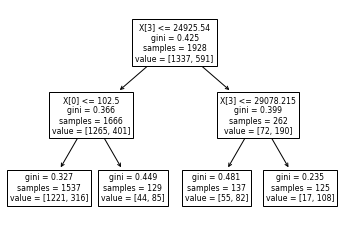

In [25]:
from sklearn.datasets import load_iris
from sklearn import tree
model = DecisionTreeClassifier(max_depth=2, random_state=12345)
model.fit(features_train, target_train)
tree.plot_tree(model)
plt.show()

наверное первое

### RandomForestClassifier

In [22]:
best_model_RFC = None
best_result_RFC = 0
best_est_RFC = 0
best_depth_RFC = 0
for est in tqdm(range(3,58)):
    for depth in range (1, 11):
        model_RFC = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model_RFC.fit(features_train, target_train) 
        predictions_valid_RFC = model_RFC.predict(features_valid)
        result_RFC = accuracy_score(target_valid, predictions_valid_RFC) 
        if result_RFC > best_result_RFC:
            best_model_RFC = model_RFC
            best_result_RFC = result_RFC
            best_est_RFC = est
            best_depth_RFC = depth 
print("Оценка правильности наилучшей модели на валидационной выборке:", best_result_RFC, 
      "Количество деревьев:", best_est_RFC, "Максимальная глубина:", best_depth_RFC)

100%|██████████| 55/55 [00:46<00:00,  1.19it/s]

Оценка правильности наилучшей модели на валидационной выборке: 0.8211508553654744 Количество деревьев: 20 Максимальная глубина: 6


Для модели best_model_RFC случайные лес оценка правильности равна 0.8133748055987559.

### LogisticRegression

In [12]:
model_LR = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_LR.fit(features_train, target_train) 
predictions_valid_LR = model_LR.predict(features_valid) 
result_LR = accuracy_score(target_valid, predictions_valid_LR)
print("Оценка правильности наилучшей модели на валидационной выборке:", result_LR)

Оценка правильности наилучшей модели на валидационной выборке: 0.6842923794712286


Для модели model_LR линейная регрессия оценка правильности равна 0.6842923794712286.

Наилучшая модел с самым высоким показателей это случайные лес:best_model_RFC (оценка=0.8133748055987559)

* может быть переобучение, на train наверное так же себя вела.
* Из-за того что у RF не такая сильная точость как у остальных
* В отличие от обычной регрессии, в методе логистической регрессии не производится предсказание значения числовой переменной исходя из выборки исходных значений. Вместо этого, значением функции является вероятность того, что данное исходное значение принадлежит к определенному классу. Постранство разделено линиеной границей - прямой, и точки исходных данных разделены в записимости от прямой или плоскости по разные стороны. 
* Может быть потому что Лоическая регрессия требует усреднения или отсутствия мультиколлинеарности между независимыми переменными.

## Проверьте модель на тестовой выборке

Проверим  качество модели на тестовой выборке.

In [14]:
best_model_RFC

RandomForestClassifier(max_depth=9, n_estimators=8, random_state=12345)

In [15]:
predictions_test_RFC = best_model_RFC.predict(features_test)

In [17]:
print('Лучшая модель best_model_RFC: ',accuracy_score(target_test, predictions_test_RFC))

Лучшая модель best_model_RFC:  0.7791601866251944


На тестовой выборки лучшя модель показала оценку качества чуть ниже: 0.779, а была 0.813. 

* Мы потом можем новых клиентов анализировать и модель будет предсказывать какой тариф он выберет и благодаря этому компания может опираясь на это добавлять какие то фишки, или подстраивать так что бы клиент выбрал более выгодный тариф для компании.
* Прочитаю про метрики чуть позже, не успеваю подготовится к экзаменам в универе, извините, потом вернусь сама доделаю, думаю в первом и последнем пункте я разберусь. 

## (бонус) Проверьте модели на адекватность

In [18]:
importances = best_model_RFC.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,mb_used,0.339895
1,messages,0.230718
2,minutes,0.223804
3,calls,0.205584


Самый важный признак количество используемых МБ.

DummyClassifier от Sklearn — это классификатор, который использует очень простые правила и полезен в качестве простой основы для сравнения других классификаторов.Ожидается, что любой другой классификатор будет лучше работать с данным набором данных. 

In [19]:
dummy_clf = DummyClassifier(strategy = "most_frequent", random_state=12345).fit(features_train, target_train)
score = dummy_clf.score(features_train, target_train)
score


0.6924273858921162

In [20]:
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(features_train, target_train)
print(clf.score(features_train, target_train))

0.8241701244813278


/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Сравнивая оценки классификатора KNN с фиктивным классификатором, мы приходим к выводу, что классификатор KNN на самом деле является хорошим классификатором для данных данных или другой вид модели классификаторов.

Так же наша лучша выбранная модель best_model_RFC имеет больший показатель accuracy чем фиктивный классификатор.
Получается что  фиктивный классификатор может ошибится в 30% случаев. А наша модель в best_model_RFC в 20%.

In [21]:
target_train.value_counts()

0    1335
1     593
Name: is_ultra, dtype: int64

In [22]:
1335 / (1335 + 593)

0.6924273858921162

Лучшая модель с самой большой оценкой это случайные лес, проверка на тестовой выбоке подтвердила это, так как достинута accuracy не меньше 0.75. Модель прошла оценку на адекватность и подтвердила ее. 

## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
